In [4]:
#mount to google drive account
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
#import required modules
import os
import re
import time
import nltk
import torch

import numpy as np
import pandas as pd
from torch import nn
import seaborn as sns
from tqdm import tqdm

import torch.nn.utils.prune as prune
import torch.nn.functional as F
from torch.optim import Adam
from bs4 import BeautifulSoup
from collections import Counter
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

from nltk.stem import WordNetLemmatizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.tokenize import word_tokenize, sent_tokenize
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix

# download the NLTK resources needed
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [6]:
# path to your processed CSV file
data = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/IP_MSC/IMDb_processed.csv')

In [10]:
data.head()

,preprocessed,label
0,One reviewer mentioned watching Oz episode hoo...,1
1,wonderful little production . filming techniqu...,1
2,thought wonderful way spend time hot summer we...,1
3,Basically family little boy Jake think zombie ...,0
4,Petter Mattei Love Time Money visually stunnin...,1


In [11]:
# check the length of the processed reviews
data['review_length']=data['preprocessed'].apply(lambda x: len(x.split()))
data.head()

Output hidden; open in https://colab.research.google.com to view.

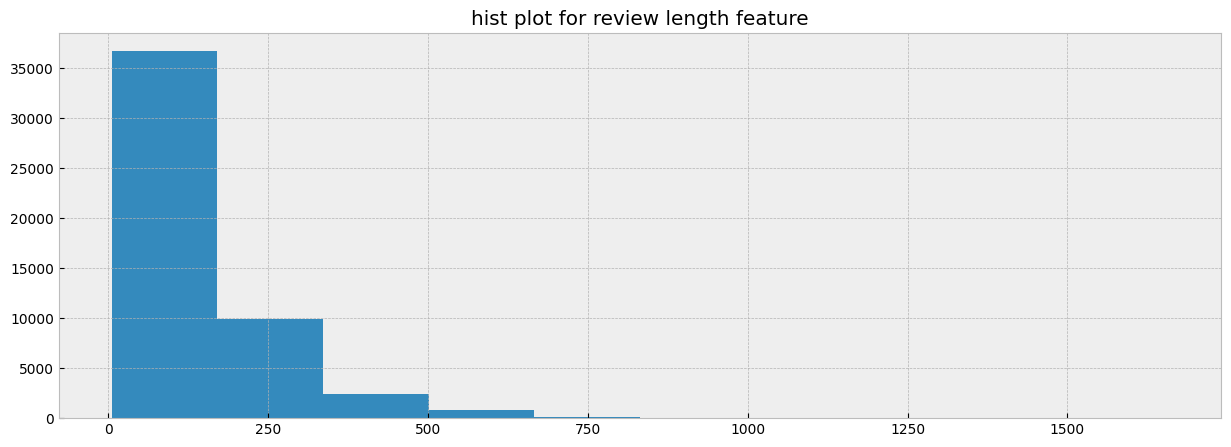

In [13]:
with plt.style.context(style='bmh'):
    data['review_length'].hist(figsize=(15,5))
    plt.title(label='hist plot for review length feature')
    plt.show()

In [14]:
# get all processed reviews
reviews = data.preprocessed.values

# merge into single variable, separated by whitespaces
words = ' '.join(reviews)

# obtain list of words
words = words.split()

# building a vocabulary and creating mappings between words and integers using a Counter
# count the occurrences of words.

# counting the occurrences of each word
counter = Counter(words)

# sorting the words by their frequency in descending order
vocab = sorted(counter, key=counter.get, reverse=True)

# Create a mapping from integer to word
int2word = dict(enumerate(vocab, 1))

# Add a special token for padding at index 0
int2word[0] = '<PAD>'

# creating a mapping from word to integer
word2int = {word: id for id, word in int2word.items()}

# encoding the words in the reviews text
# by using the word-to-integer mapping to replace words with their integer indices
reviews_encoded = [[word2int[word] for word in review.split()] for review in tqdm(reviews)]

# showing the 10 encoded words for the first 5 reviews
for i in range(5):
    print(f"Review {i + 1}: {reviews_encoded[i][:10]}")

100%|██████████| 50000/50000 [00:01<00:00, 31645.50it/s]

Review 1: [172, 1023, 873, 70, 3614, 167, 2924, 1, 102, 2]
Review 2: [300, 50, 220, 1, 1204, 1535, 17655, 3, 74, 3]
Review 3: [84, 300, 26, 983, 10, 788, 1697, 2532, 2, 1067]
Review 4: [2314, 121, 50, 217, 3121, 33, 607, 4182, 542, 825]
Review 5: [70690, 10390, 1021, 1859, 7387, 2190, 1248, 5, 40, 1]


In [15]:
# Padding sequences function - reviews do not have the same length so we will need set a max sequence length
def pad_features(reviews, pad_id, seq_length=128):
    # Creating a matrix to store the padded features
    features = np.full((len(reviews), seq_length), pad_id, dtype=int)
    # Looping through each review and pad or trim to the specified sequence length
    for i, row in enumerate(reviews):
        # If the review is longer than seq_length, trim it
        features[i, :len(row)] = np.array(row)[:seq_length]
    return features

# Set the desired sequence length
seq_length = 128

# Padding the encoded reviews using the pad_features function
features = pad_features(reviews_encoded, pad_id=word2int['<PAD>'], seq_length=seq_length)

# Assertions to check the dimensions
assert len(features) == len(reviews_encoded)
assert len(features[0]) == seq_length

# Print the first 10 rows and columns for inspection
print(features[:10, :10])

[[  172  1023   873    70  3614   167  2924     1   102     2]
 [  300    50   220     1  1204  1535 17655     3    74     3]
 [   84   300    26   983    10   788  1697  2532     2  1067]
 [ 2314   121    50   217  3121    33   607  4182   542   825]
 [70690 10390  1021  1859  7387  2190  1248     5    40     1]
 [ 2691     3    10   337     4     2    13 42241     2  2846]
 [  178    14     8    17 12322  1823 55638   106  4989   379]
 [   27   389     2  1276  3908   147    30  2854     1    30]
 [47622   922   330     5   162   722    70     5     1  1242]
 [    8   110  2179  5479  1896     8     4     1   107    74]]


In [16]:
# create numpy array for labels column
labels = data.label.to_numpy()

In [17]:
# Train-Test split parameters
train_size = 0.7  # We will use 70% of the whole data as the training set
val_size = 0.3    # We will use 30% of the remaining data as the validation set

# Make the training set
split_id = int(len(features) * train_size)
train_x, remain_x = features[:split_id], features[split_id:]
train_y, remain_y = labels[:split_id], labels[split_id:]

# Making validation and test sets
split_val_id = int(len(remain_x) * val_size)
val_x, test_x = remain_x[:split_val_id], remain_x[split_val_id:]
val_y, test_y = remain_y[:split_val_id], remain_y[split_val_id:]

# Printing out the shape of the datasets
print('Feature Shapes:')
print('===============')
print('Train set: {}'.format(train_x.shape))
print('Validation set: {}'.format(val_x.shape))
print('Test set: {}'.format(test_x.shape))

# Print the class distribution in each set
print(len(train_y[train_y == 0]), len(train_y[train_y == 1]))
print(len(val_y[val_y == 0]), len(val_y[val_y == 1]))
print(len(test_y[test_y == 0]), len(test_y[test_y == 1]))

Feature Shapes:
Train set: (35000, 128)
Validation set: (4500, 128)
Test set: (10500, 128)
17510 17490
2243 2257
5247 5253


In [18]:
# Defining the batch size
batch_size = 64

# Creating tensor datasets
trainset = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
validset = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
testset = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# Creating data loaders
trainloader = DataLoader(trainset, shuffle=True, batch_size=batch_size)
valloader = DataLoader(validset, shuffle=True, batch_size=batch_size)
testloader = DataLoader(testset, shuffle=True, batch_size=batch_size)

In [19]:
# Check sample batches from the training loader
dataiter = iter(trainloader)
x, y = next(dataiter)

# Print information about the sample batch
print('Sample batch size: ', x.size())   # batch_size, seq_length
print('Sample batch input: \n', x)
print()
print('Sample label size: ', y.size())   # batch_size
print('Sample label input: \n', y)

Sample batch size:  torch.Size([64, 128])
Sample batch input: 
 tensor([[16049,  2167, 49452,  ...,     0,     0,     0],
        [ 2129,   181,     3,  ...,     0,     0,     0],
        [ 4762,   492,    70,  ...,   135,   765, 42258],
        ...,
        [  479,     8, 14223,  ...,     0,     0,     0],
        [  819,    27,     7,  ...,     0,     0,     0],
        [ 3433,  2165, 31330,  ...,  2245,     2,   666]])

Sample label size:  torch.Size([64])
Sample label input: 
 tensor([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
        0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1])


In [20]:
torch.cuda.is_available()
# ref: https://stackoverflow.com/questions/50560395/how-to-install-cuda-in-google-colab-gpus
# Output would be True if Pytorch is using GPU otherwise it would be False.

True

In [21]:
# define training device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [22]:
# Model architecture for sentiment analysis using an LSTM-based neural network
class SentimentModel(nn.Module):
    def __init__(self, vocab_size, output_size, hidden_size=128, embedding_size=400, n_layers=2, dropout=0.2):
        super(SentimentModel, self).__init__()

        # Embedding layer to map input tokens into vector representations
        self.embedding = nn.Embedding(vocab_size, embedding_size)

        # LSTM layer provided by PyTorch library
        self.lstm = nn.LSTM(embedding_size, hidden_size, n_layers, dropout=dropout, batch_first=True)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(0.3)

        # Linear layer for the final output
        self.fc = nn.Linear(hidden_size, output_size)

        # Sigmoid layer as we are performing binary classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Convert input features to the 'long' data type
        x = x.long()

        # Map input tokens to vector representations using the embedding layer
        x = self.embedding(x)

        # Pass the input forward through the LSTM layer
        o, _ = self.lstm(x)

        # Retrieve the last output of the sequence
        o = o[:, -1, :]

        # Apply dropout and pass through the fully connected layer
        o = self.dropout(o)
        o = self.fc(o)

        # Apply sigmoid activation for binary classification
        o = self.sigmoid(o)

        return o
# reference used: https://galhever.medium.com/sentiment-analysis-with-pytorch-part-3-cnn-model-7bb30712abd7

In [23]:
# Model hyperparameters
# - `vocab_size`: The size of the vocabulary, representing the number of unique tokens in the input data.
# - `output_size`: The size of the output, typically 1 for binary classification (positive or negative sentiment).
# - `embedding_size`: The dimensionality of the embedding vectors used to represent each token in the input.
# - `hidden_size`: The number of hidden units in the LSTM layer, determining the capacity of the model to capture information.
# - `n_layers`: The number of layers in the LSTM, allowing the model to learn hierarchical features.
# - `dropout`: The dropout rate, a regularization technique applied to prevent overfitting by randomly dropping units during training.
vocab_size = len(word2int)  # Assuming `word2int` is a mapping of words to unique integer indices
output_size = 1
embedding_size = 256
hidden_size = 512
n_layers = 2
dropout = 0.25

# Model initialization
# - Create an instance of the SentimentModel class with the specified hyperparameters.
# - This initializes the neural network with the defined architecture and sets the hyperparameters.
model = SentimentModel(vocab_size, output_size, hidden_size, embedding_size, n_layers, dropout)
print(model)

SentimentModel(
  (embedding): Embedding(120982, 256)
  (lstm): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [24]:
# Training configuration
lr = 0.001
criterion = nn.BCELoss()
optim = Adam(model.parameters(), lr=lr)
grad_clip = 5
epochs = 10
print_every = 1
history = {'train_loss': [],
           'train_acc': [],
           'val_loss': [],
           'val_acc': [],
           'epochs': epochs}
es_limit = 5

# Train loop
model = model.to(device)
epochloop = tqdm(range(epochs), position=0, desc='Training', leave=True)

# Early stop trigger
es_trigger = 0
val_loss_min = np.Inf

# Training and Validation Loop

for e in epochloop:

    # training mode

    # Set the model to training mode to enable gradient calculation
    model.train()

    train_loss = 0
    train_acc = 0

    # Iterate over training batches
    for id, (feature, target) in enumerate(trainloader):
        # Add epoch meta info
        epochloop.set_postfix_str(f'Training batch {id}/{len(trainloader)}')

        # Move data to the device
        feature, target = feature.to(device), target.to(device)

        # Reset optimizer
        optim.zero_grad()

        # Forward pass
        out = model(feature)

        # Calculate accuracy
        predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
        equals = predicted == target
        acc = torch.mean(equals.type(torch.FloatTensor))
        train_acc += acc.item()

        # Calculate loss and perform backpropagation
        loss = criterion(out.squeeze(), target.float())
        train_loss += loss.item()
        loss.backward()

        # Clip gradients to prevent exploding gradients
        nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

        # Update optimizer
        optim.step()

        # Free some memory
        del feature, target, predicted

    # Store training metrics
    history['train_loss'].append(train_loss / len(trainloader))
    history['train_acc'].append(train_acc / len(trainloader))


    # validation mode

    # Set the model to evaluation mode to disable gradient calculation
    model.eval()

    val_loss = 0
    val_acc = 0

    with torch.no_grad():
        # Iterate over validation batches
        for id, (feature, target) in enumerate(valloader):
            # Add epoch meta info
            epochloop.set_postfix_str(f'Validation batch {id}/{len(valloader)}')

            # Move data to the device
            feature, target = feature.to(device), target.to(device)

            # Forward pass
            out = model(feature)

            # Calculate accuracy
            predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
            equals = predicted == target
            acc = torch.mean(equals.type(torch.FloatTensor))
            val_acc += acc.item()

            # Calculate loss
            loss = criterion(out.squeeze(), target.float())
            val_loss += loss.item()

            # Free some memory
            del feature, target, predicted

        # Store validation metrics
        history['val_loss'].append(val_loss / len(valloader))
        history['val_acc'].append(val_acc / len(valloader))

    # Reset model to training mode
    model.train()

    # Add epoch meta info
    epochloop.set_postfix_str(f'Val Loss: {val_loss / len(valloader):.3f} | Val Acc: {val_acc / len(valloader):.3f}')

    # Print epoch information
    if (e+1) % print_every == 0:
        epochloop.write(f'Epoch {e+1}/{epochs} | Train Loss: {train_loss / len(trainloader):.3f} Train Acc: {train_acc / len(trainloader):.3f} | Val Loss: {val_loss / len(valloader):.3f} Val Acc: {val_acc / len(valloader):.3f}')
        epochloop.update()

    # Save model if validation loss decreases
    if val_loss / len(valloader) <= val_loss_min:
        torch.save(model.state_dict(), './sentiment_lstm.pt')
        val_loss_min = val_loss / len(valloader)
        es_trigger = 0
    else:
        epochloop.write(f'[WARNING] Validation loss did not improve ({val_loss_min:.3f} --> {val_loss / len(valloader):.3f})')
        es_trigger += 1

    # Force early stop
    if es_trigger >= es_limit:
        epochloop.write(f'Early stopped at Epoch-{e+1}')
        # Update epochs history
        history['epochs'] = e+1
        break


Training:  10%|█         | 1/10 [00:21<03:16, 21.81s/it, Val Loss: 0.693 | Val Acc: 0.515]

Epoch 1/10 | Train Loss: 0.694 Train Acc: 0.515 | Val Loss: 0.693 Val Acc: 0.515


Training:  30%|███       | 3/10 [00:42<01:40, 14.42s/it, Training batch 5/547]

Epoch 2/10 | Train Loss: 0.694 Train Acc: 0.505 | Val Loss: 0.695 Val Acc: 0.504
[WARNING] Validation loss did not improve (0.693 --> 0.695)


Training:  40%|████      | 4/10 [01:03<01:41, 16.87s/it, Val Loss: 0.692 | Val Acc: 0.505]

Epoch 3/10 | Train Loss: 0.694 Train Acc: 0.505 | Val Loss: 0.692 Val Acc: 0.505


Training:  60%|██████    | 6/10 [01:24<00:56, 14.20s/it, Training batch 5/547]

Epoch 4/10 | Train Loss: 0.694 Train Acc: 0.499 | Val Loss: 0.692 Val Acc: 0.506
[WARNING] Validation loss did not improve (0.692 --> 0.692)


Training:  70%|███████   | 7/10 [01:45<00:48, 16.32s/it, Val Loss: 0.606 | Val Acc: 0.631]

Epoch 5/10 | Train Loss: 0.667 Train Acc: 0.554 | Val Loss: 0.606 Val Acc: 0.631


Training:  80%|████████  | 8/10 [02:06<00:35, 17.82s/it, Val Loss: 0.558 | Val Acc: 0.669]

Epoch 6/10 | Train Loss: 0.561 Train Acc: 0.670 | Val Loss: 0.558 Val Acc: 0.669


Training: 100%|██████████| 10/10 [02:27<00:00, 14.92s/it, Val Loss: 0.427 | Val Acc: 0.810]

Epoch 7/10 | Train Loss: 0.460 Train Acc: 0.746 | Val Loss: 0.427 Val Acc: 0.810


Training: 11it [02:47, 16.76s/it, Val Loss: 0.391 | Val Acc: 0.836]                        

Epoch 8/10 | Train Loss: 0.284 Train Acc: 0.894 | Val Loss: 0.391 Val Acc: 0.836


Training: 12it [03:09, 18.04s/it, Training batch 5/547]

Epoch 9/10 | Train Loss: 0.185 Train Acc: 0.937 | Val Loss: 0.411 Val Acc: 0.843
[WARNING] Validation loss did not improve (0.391 --> 0.411)


Training: 100%|██████████| 10/10 [03:29<00:00, 20.96s/it, Val Loss: 0.484 | Val Acc: 0.839]

Epoch 10/10 | Train Loss: 0.114 Train Acc: 0.965 | Val Loss: 0.484 Val Acc: 0.839
[WARNING] Validation loss did not improve (0.391 --> 0.484)


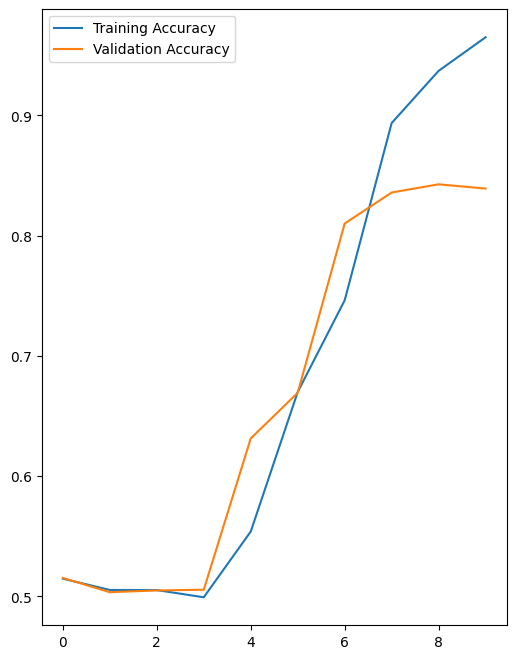

In [26]:
# plotting loss
plt.figure(figsize=(6, 8))
plt.plot(range(history['epochs']), history['train_acc'], label='Training Accuracy')
plt.plot(range(history['epochs']), history['val_acc'], label='Validation Accuracy')
plt.legend()
plt.show()

In [27]:
# predicting data with unseen data which wasn't included in training
# test loop
model.eval()

# metrics
test_loss = 0
test_acc = 0

all_target = []
all_predicted = []

testloop = tqdm(testloader, leave=True, desc='Inference')
with torch.no_grad():
    for feature, target in testloop:
        feature, target = feature.to(device), target.to(device)

        out = model(feature)

        predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
        equals = predicted == target
        acc = torch.mean(equals.type(torch.FloatTensor))
        test_acc += acc.item()

        loss = criterion(out.squeeze(), target.float())
        test_loss += loss.item()

        all_target.extend(target.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())

    print(f'Accuracy: {test_acc/len(testloader):.4f}, Loss: {test_loss/len(testloader):.4f}')

Inference: 100%|██████████| 165/165 [00:02<00:00, 78.46it/s]

Accuracy: 0.8384, Loss: 0.4740


              precision    recall  f1-score   support

           0       0.80      0.86      0.83      4876
           1       0.87      0.82      0.84      5624

    accuracy                           0.84     10500
   macro avg       0.84      0.84      0.84     10500
weighted avg       0.84      0.84      0.84     10500



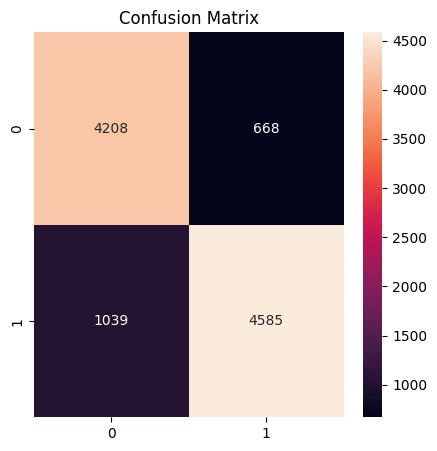

In [28]:
# print out classification report
print(classification_report(all_predicted, all_target))

# plot confusion matrix
cm = confusion_matrix(all_predicted, all_target)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.show()

In [31]:
from torch.nn.utils import prune
# reference: https://towardsdatascience.com/how-to-prune-neural-networks-with-pytorch-ebef60316b91

# apply pruning
# Specify the layer to prune
layer_to_prune = 'fc'

# Percentage of connections to prune
prune_percentage = 30

# Use L1Unstructured pruning method
prune.l1_unstructured(model.fc, name='weight', amount=prune_percentage / 100.0)


Linear(in_features=512, out_features=1, bias=True)